In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict 

import nbimporter
from Time_synchronization import get_hipnogram_intersection 
import parse_hipnogram as ph


loading


In [44]:
# Receiver operator analysis, i.e. basic signal detection measures
def get_roc(permute = False):
    psg_hipno = ph.parse_psg_stages()
    noo_hipno = ph.parse_neuroon_stages(permute = permute)
    
    # Get the start and end of the time window covered by both hipnograms
    start = noo_hipno.index.searchsorted(psg_hipno.index.get_values()[0])
    end = psg_hipno.index.searchsorted(noo_hipno.index.get_values()[-1])
    
    # Trim hipnograms to the common time window so the confusion matrix calculations are accurate
    # +1 and -1 because events got cut in half, resulting in ends without starts
    noo_hipno = noo_hipno.ix[start +1::]
    psg_hipno = psg_hipno.ix[0:end -1]
    
    psg_total = calc_times(ph.prep_for_phases(psg_hipno.copy()))
    neuroon_total= calc_times(ph.prep_for_phases(noo_hipno.copy()))
    
    neuroon_correct, _, _ = get_hipnogram_intersection(psg_hipno.copy(), noo_hipno.copy(), 0)

    all_confusion_matrixes = {}
    all_cl_params = {}
    for stage in list(neuroon_total.keys()):
        
         #The time neuroon said it was not this stage
        neuroon_negative = np.array([neuroon_total[key] for key in list(neuroon_total.keys()) if key != stage]).sum()
        # The time psg said it was not this stage
        subset = list(neuroon_total.keys())
        subset.extend(['N1', 'wake'])# These keys are not in neuroon

        psg_negative = np.array([psg_total[key] for key in subset if key != stage]).sum()
        
        true_positive = neuroon_correct[stage] / psg_total[stage]
        true_negative = neuroon_negative/ psg_negative

        false_positive = (neuroon_total[stage] - neuroon_correct[stage]) / psg_negative 
        false_negative =  (psg_total[stage] - neuroon_correct[stage]) / neuroon_negative 
#        
        confusion_matrix ={'true_positive' : true_positive, 'false_positive' : false_positive,'false_negative':false_negative, 'true_negative' : true_negative}

        all_confusion_matrixes[stage] = confusion_matrix
        
        cl_params = {}
        cl_params['precision'] = true_positive / (true_positive + false_positive)
        cl_params['recall'] = true_positive / (true_positive + false_negative)
        cl_params['accuracy'] = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        
        all_cl_params[stage] = cl_params
        
    #if(permute == False):
        #plot_roc(all_confusion_matrixes, all_cl_params)
    
    return all_confusion_matrixes, all_cl_params

In [45]:
def calc_times(hipno):
    
    stage_durations = OrderedDict()

    for name, sleep_stage in hipno.groupby('stage_name'):
    
        for idx, stage_event in sleep_stage.iterrows():
            duration = (stage_event['ends'] -  stage_event['starts']).total_seconds()
            
            if stage_event['stage_name'] not in stage_durations.keys():
                # Divide to get minutes
                stage_durations[stage_event['stage_name']] = duration
            else:
                stage_durations[stage_event['stage_name']] += duration
    
    
    return stage_durations

In [46]:
a, b = get_roc(permute = False)

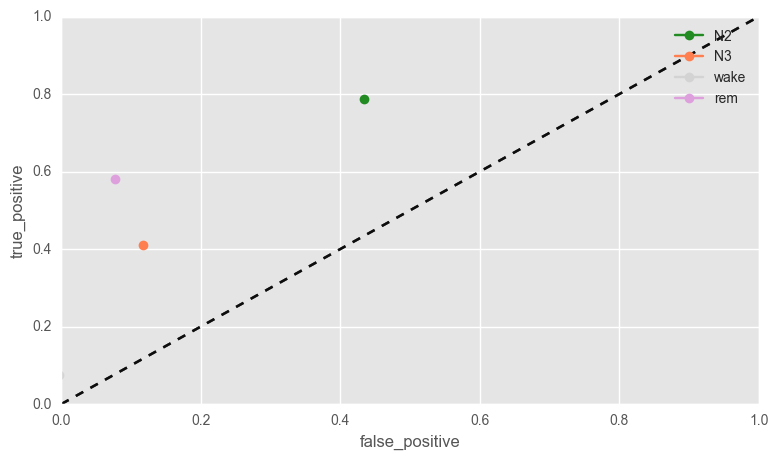

In [50]:
from plotting_collection import plot_roc
# Diagaonal line represents results obtained from a random process. Deviation from diagonal shows accutate classifier performance.
# Top left corner is ideal performance
plot_roc(a,b)


In [51]:
def run_permute():
    fig, axes = plt.subplots()
    
    orig_confusion_matrixes, orig_cl_params = get_roc(permute = False)

    for i in range(30):
        print(i)
        all_confusion_matrixes, all_cl_params = get_roc(permute = True)
        tp, fp = all_confusion_matrixes['N2']['true_positive'], all_confusion_matrixes['N2']['false_positive']
        axes.plot(fp, tp, color = 'r', marker = 'o', alpha = 0.5)
    
    axes.plot(orig_confusion_matrixes['N2']['false_positive'], orig_confusion_matrixes['N2']['true_positive'], color = 'b', marker = 'o', alpha = 1)
    
    axes.plot([0,1], [0,1], color = 'black', linestyle = '--', alpha = 0.5)
    axes.set_xlabel('false_positive')
    axes.set_ylabel('true_positive')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


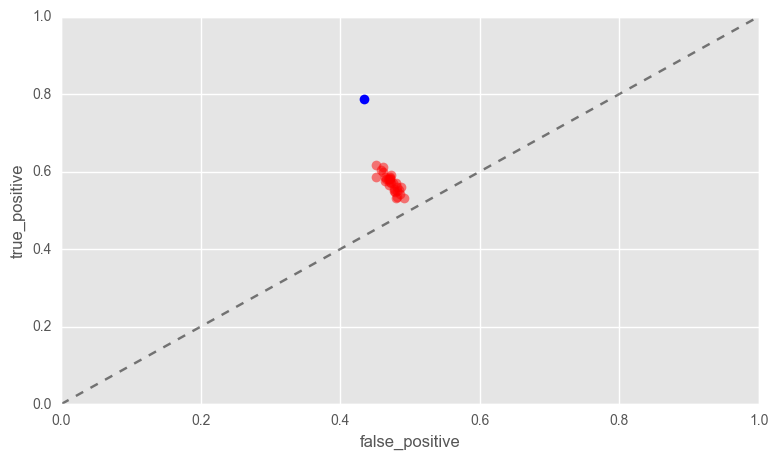

In [52]:
run_permute()

TODO
* Add Cohen cappa from stats
* Add permutation for all stages, change makers